In [1]:
import pandas as pd
import numpy as np
from pathlib import Path



In [2]:
ratings = pd.read_csv('../subset_ratings.csv')

SPARSITY_LEVELS = {
    'L0': 1.0,   # no removal—“standard” data
    'L1': 0.5,   # moderate sparsity
    'L2': 0.2,   # heavy sparsity
}

In [3]:
def generate_sparsity_level(ratings: pd.DataFrame, keep_frac: float) -> pd.DataFrame:
    def sample_user(df):
        n_keep = max(1, int(len(df) * keep_frac))
        return df.sample(n_keep, random_state=42)
    
    return ratings.groupby('userId', group_keys=False).apply(sample_user).reset_index(drop=True)
unique_users = ratings.userId.drop_duplicates()
top_movies  = ratings.movieId.value_counts().nlargest(500).index
top_users   = ratings.userId.drop_duplicates().sample(len(unique_users), random_state=42)

dev = ratings[
    ratings.movieId.isin(top_movies) &
    ratings.userId .isin(top_users)
].copy()

print(f"Original ratings shape: {ratings.shape}")
print(f"Filtered ratings shape: {dev.shape}")

# # Create splits
# splits = {
#     lvl: generate_sparsity_level(ratings, frac)
#     for lvl, frac in SPARSITY_LEVELS.items()
# }

# Create splits
splits = {
    lvl: generate_sparsity_level(dev, frac)
    for lvl, frac in SPARSITY_LEVELS.items()
}



Original ratings shape: (2078625, 4)
Filtered ratings shape: (978786, 4)


In [4]:
print(splits['L0'].shape)

(978786, 4)


In [5]:
def compute_stats(df: pd.DataFrame):
    num_users   = df['userId'].nunique()
    num_items   = df['movieId'].nunique()
    num_ratings = len(df)
    # global sparsity: 1 − (#interactions)/(#users × #items)
    sparsity = 1 - num_ratings / (num_users * num_items)
    return num_users, num_items, num_ratings, sparsity

# Build a severity table
rows = []
for lvl, df in splits.items():
    users, items, ints, spa = compute_stats(df)
    rows.append({
        'Level': lvl,
        'NumUsers': users,
        'NumItems': items,
        'NumInteractions': ints,
        'SparsityRatio': spa
    })

severity_df = pd.DataFrame(rows).sort_values('Level')
print(severity_df)


  Level  NumUsers  NumItems  NumInteractions  SparsityRatio
0    L0      9999       500           978786       0.804223
1    L1      9999       500           486856       0.902619
2    L2      9999       500           191734       0.961649


In [6]:
import numpy as np

def make_pure_cold_start_splits(ratings: pd.DataFrame,
                                user_cold_frac: float = 0.05,
                                item_cold_frac: float = 0.05,
                                seed: int = 42):
    """
    Returns:
      train_df        – all ratings except those from cold users/items
      user_cold_test  – all ratings of held-out users
      item_cold_test  – all ratings of held-out items (excluding user_cold users)
    """
    rng = np.random.default_rng(seed)
    
    # 1) pick cold users
    all_users = ratings['userId'].unique()
    n_user_cold = int(len(all_users) * user_cold_frac)
    user_cold = set(rng.choice(all_users, n_user_cold, replace=False))
    
    # 2) pick cold items
    all_items = ratings['movieId'].unique()
    n_item_cold = int(len(all_items) * item_cold_frac)
    item_cold = set(rng.choice(all_items, n_item_cold, replace=False))
    
    # 3) split out their ratings
    user_cold_test = ratings[ratings['userId'].isin(user_cold)]
    # for item_cold, make sure we don’t re-test the same rows twice
    remaining   = ratings[~ratings.index.isin(user_cold_test.index)]
    item_cold_test = remaining[remaining['movieId'].isin(item_cold)]
    
    # 4) everything else is training data
    train_idx = ratings.index.difference(user_cold_test.index).difference(item_cold_test.index)
    train_df  = ratings.loc[train_idx].reset_index(drop=True)
    
    return train_df, user_cold_test.reset_index(drop=True), item_cold_test.reset_index(drop=True)

# # Example usage:
# train_all, user_cold_test, item_cold_test = make_pure_cold_start_splits(ratings,
#                                                                        user_cold_frac=0.05,
#                                                                        item_cold_frac=0.05)

# # Now you can:
# #  - train on `train_all`
# #  - evaluate separately on `user_cold_test` (pure user cold-start)
# #  - evaluate on `item_cold_test` (pure item cold-start)


In [7]:
# outdir = Path('./sparse_data')

# for lvl, df in splits.items():
#     df.to_csv(outdir / f'ratings_{lvl}.csv', index=False)

# severity_df.to_csv(outdir / 'dataset_severity.csv', index=False)


In [8]:
# Movie norm support
movie_tag_matrix = pd.read_csv("../subset_movie_tag_matrix.csv", index_col=0)
movie_tag_matrix.index = movie_tag_matrix.index.astype(int)
print("Loaded tag‑matrix shape:", movie_tag_matrix.shape)

Loaded tag‑matrix shape: (7008, 1128)


In [9]:
row_norms   = np.linalg.norm(movie_tag_matrix.values, axis=1)
movie_norm  = movie_tag_matrix.div(
    pd.Series(row_norms, index=movie_tag_matrix.index).replace(0, 1),
    axis=0,
)

# Evaluation

In [10]:
# Knn
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_distances
from collections import defaultdict
import numpy as np

class KNNModel:
    def __init__(self, K=80, shrink=25):
        self.K = K
        self.shrink = shrink

    def fit(self, train_df):
        # 1. build index maps
        
        self.uid2idx = {u:i for i,u in enumerate(train_df.userId.unique())}
        self.mid2idx = {m:i for i,m in enumerate(train_df.movieId.unique())}
        self.idx2mid = {i:m for m,i in self.mid2idx.items()}
        self.n_users = len(self.uid2idx)
        self.n_items = len(self.mid2idx)

        # 2. build item×user sparse matrix
        rows = train_df.movieId.map(self.mid2idx)
        cols = train_df.userId.map(self.uid2idx)
        data = train_df.rating.values
        mat = csr_matrix((data,(rows,cols)),
                         shape=(self.n_items, self.n_users))
        self.train_mat = mat

        # 3. compute item means
        print("  [KNN] computing item means…", flush=True)

        item_sum    = np.asarray(mat.sum(axis=1)).ravel()
        item_counts = np.diff(mat.indptr)
        self.item_means = np.divide(item_sum, item_counts,
                                    out=np.zeros_like(item_sum, float),
                                    where=item_counts>0)

        # 4. mean-centered ratings for similarity
        print("  [KNN] mean-centering ratings…", flush=True)

        mat_mc = mat.copy().astype(np.float32)
        for i in range(self.n_items):
            start,end = mat_mc.indptr[i], mat_mc.indptr[i+1]
            mat_mc.data[start:end] -= self.item_means[i]

        # 5. cosine similarity + shrinkage
        print("  [KNN] computing cosine distances…", flush=True)

        dist    = cosine_distances(mat_mc)
        sim     = 1 - dist
        np.fill_diagonal(sim, 0)
        # co-ratings count for shrinkage
        binary  = (mat>0).astype(int)
        co_counts = (binary @ binary.T).toarray()
        shrink_w  = co_counts / (co_counts + self.shrink)
        sim *= shrink_w

        # 6. keep top-K per item in a CSR
        print(f"  [KNN] building top-{self.K} neighbors…", flush=True)
        from scipy.sparse import lil_matrix
        sim_mat = lil_matrix(sim.shape, dtype=np.float32)
        for i in range(self.n_items):
            if self.K >= self.n_items:
                nbrs = np.argsort(sim[i])[::-1]
            else:
                nbrs = np.argpartition(sim[i], -self.K)[-self.K:]
                nbrs = nbrs[np.argsort(sim[i][nbrs])[::-1]]
            vals = sim[i, nbrs]
            mask = vals > 0
            sim_mat.rows[i] = nbrs[mask].tolist()
            sim_mat.data[i] = vals[mask].tolist()

        self.sim_mat = sim_mat.tocsr()
        self.sim_abs = self.sim_mat.copy();  self.sim_abs.data = np.abs(self.sim_abs.data)

        # 7. build per-user rating dict for fast lookup
        print("  [KNN] building user_rated dict…", flush=True)
        self.user_rated = defaultdict(dict)
        for r in train_df.itertuples():
            self.user_rated[r.userId][ self.mid2idx[r.movieId] ] = r.rating

    def _predict_one(self, uid, iid):
        """Mean-centered, similarity-weighted prediction."""
        rated = self.user_rated.get(uid, {})
        if not rated:
            return self.item_means[iid]
        start,end = self.sim_mat.indptr[iid], self.sim_mat.indptr[iid+1]
        numer = denom = 0.0
        for nbr, sim in zip(self.sim_mat.indices[start:end], self.sim_mat.data[start:end]):
            if nbr not in rated or sim <= 0:
                continue
            numer += sim * (rated[nbr] - self.item_means[nbr])
            denom += abs(sim)
        return self.item_means[iid] if denom == 0 else self.item_means[iid] + numer/denom

    def predict(self, test_df):
        preds = []
        for r in test_df.itertuples():
            # map movieId to our internal idx; fall back to mean if unseen
            iid = self.mid2idx.get(r.movieId, None)
            if iid is None:
                preds.append(self.item_means.mean())
            else:
                preds.append(self._predict_one(r.userId, iid))
        return np.array(preds)
    
    def top_n(self, train_df, user_id, K=10):
        """
        Return a list of up to K movieIds recommended for user_id,
        in descending order of predicted score.
        """
        # 1) if the user has no history in this model, no recs
        if user_id not in self.user_rated:
            return []

        # 2) compute a score for every item
        scores = {}
        for iid in range(self.n_items):
            # predict uses mean‐centered sim weight + item mean
            score = self._predict_one(user_id, iid)
            scores[self.idx2mid[iid]] = score

        # 3) remove already seen
        seen = set(train_df[train_df.userId == user_id].movieId)
        candidates = [(m, sc) for m, sc in scores.items() if m not in seen]

        # 4) pick top K
        top = sorted(candidates, key=lambda x: -x[1])[:K]
        return [m for m, _ in top]


In [11]:
# als
import numpy as np
from scipy import sparse
from implicit.als import AlternatingLeastSquares

class ALSModel:
    def __init__(self, factors=64, regularization=0.1, iterations=15, seed=42):
        self.factors = factors
        self.reg  = regularization
        self.iters = iterations
        self.seed  = seed

    def fit(self, train_df):
        # build maps
        self.user_ids = train_df.userId.unique()
        self.item_ids = train_df.movieId.unique()
        self.uid_map = {u:i for i,u in enumerate(self.user_ids)}
        self.mid_map = {m:i for i,m in enumerate(self.item_ids)}
        # reverse map for recs
        self.idx2mid = {i:m for m,i in self.mid_map.items()}
        # build CSR (items × users)
        rows = train_df.movieId.map(self.mid_map)
        cols = train_df.userId.map(self.uid_map)
        data = train_df.rating.astype(np.float32)
        self.train_mat = sparse.csr_matrix(
            (data, (rows, cols)),
            shape=(len(self.item_ids), len(self.user_ids))
        )
        # train implicit ALS (treat rating as confidence)
        self.model = AlternatingLeastSquares(
            factors=self.factors,
            regularization=self.reg,
            iterations=self.iters,
            use_native=True,
            dtype=np.float32,
            random_state=self.seed
        )
        self.model.fit(self.train_mat)

    def predict(self, test_df):
        """
        For each (userId, movieId) in test_df, return
        either the dot(user_factors, item_factors) or
        (if out of bounds) a simple fallback.
        """
        y_pred     = []
        global_mean = float(self.train_mat.data.mean())
        n_users     = self.model.user_factors.shape[0]
        n_items     = self.model.item_factors.shape[0]

        for r in test_df.itertuples():
            u, m = r.userId, r.movieId
            ui = self.uid_map.get(u, -1)
            mi = self.mid_map.get(m, -1)
            # fallback if missing or out of learned range
            if ui < 0 or mi < 0 or ui >= n_users or mi >= n_items:
                y_pred.append(global_mean)
            else:
                y_pred.append(
                    float(self.model.user_factors[ui].dot(
                        self.model.item_factors[mi]
                    ))
                )
        return np.array(y_pred)

    def top_n(self, train_df, user_id, K=10, filter_seen=True):
        """
        Return up to K movieIds recommended for user_id,
        using the SAME train_mat you fitted.
        """
        # 1) map userId → internal index
        ui = self.uid_map.get(user_id, None)
        if ui is None:
            return []

        # 2) take the items×users matrix you already built → transpose to users×items
        user_items = self.train_mat.T.tocsr()

        # 3) ask implicit for top-K recs (these indices now line up)
        rec_iids, _ = self.model.recommend(
            userid=ui,
            user_items=user_items[ui],
            N=K,
            filter_already_liked_items=filter_seen
        )

        # 4) map back to your original movieIds
        return [self.idx2mid[i] for i in rec_iids]





In [12]:
# User-based CF
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

class DynamicCFUser:
    def __init__(self):
        # no hyper-params here, but you could add shrinkage or K if you like
        pass

    def fit(self, train_df):
        # 1) build pivot and index maps
        pivot = (
            train_df
            .pivot(index="userId", columns="movieId", values="rating")
            .fillna(0)
        )
        self.user2idx = {u:i for i,u in enumerate(pivot.index)}
        self.movie2idx= {m:i for i,m in enumerate(pivot.columns)}
        self.idx2movie= {i:m for m,i in self.movie2idx.items()}

        # 2) store data structures
        self.user_ids  = np.array(pivot.index)
        self.movie_ids = np.array(pivot.columns, dtype=int)
        self.user_vecs = pivot.values        # shape = (U × M)

        # 3) compute user×user similarity
        self.sim_mat  = cosine_similarity(self.user_vecs)   # (U×U)
        self.abs_sim  = np.sum(np.abs(self.sim_mat), axis=1)  # length U

        # global fallback if unseen
        self.global_mean = train_df.rating.mean()

    def predict(self, test_df):
        preds = []
        for r in test_df.itertuples():
            u, m = r.userId, r.movieId
            # unseen user or movie?
            if u not in self.user2idx or m not in self.movie2idx:
                preds.append(self.global_mean)
                continue

            u_idx = self.user2idx[u]
            m_idx = self.movie2idx[m]

            # cf_num: sim[user] ⋅ all users’ rating-vectors → gives a length-M array
            cf_num = self.sim_mat[u_idx].dot(self.user_vecs)
            denom  = self.abs_sim[u_idx]
            if denom > 0:
                pred = cf_num[m_idx] / denom
            else:
                pred = self.user_vecs[:, m_idx].mean()

            preds.append(pred)
        return np.array(preds)
    
    def top_n(self, train_df, user_id, K=10):
        """
        Return a list of up to K movieIds recommended for user_id,
        based on user–user CF scores.
        """
        # 1) if user unseen, no recs
        if user_id not in self.user2idx:
            return []

        # 2) compute raw CF scores for every movie
        uidx   = self.user2idx[user_id]
        cf_num = self.sim_mat[uidx].dot(self.user_vecs)   # length M
        denom  = self.abs_sim[uidx]
        if denom > 0:
            scores = cf_num / denom
        else:
            scores = np.zeros_like(cf_num)

        # 3) mask out movies the user has already rated
        seen = set(train_df[train_df.userId == user_id].movieId)
        candidates = [
            (m, sc) for m, sc in zip(self.movie_ids, scores)
            if m not in seen
        ]

        # 4) pick top K by score
        top = sorted(candidates, key=lambda x: -x[1])[:K]
        return [m for m, _ in top]



In [13]:
# Item based CF
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class DynamicCFItem:
    def __init__(self, k=None):
        """
        k = number of top neighbors to keep (None = use all)
        """
        self.k = k

    def fit(self, train_df):
        # 1) build pivot and maps
        pivot = (
            train_df
            .pivot(index="userId", columns="movieId", values="rating")
            .fillna(0)
        )
        self.user2idx = {u:i for i,u in enumerate(pivot.index)}
        self.movie2idx= {m:i for i,m in enumerate(pivot.columns)}
        self.idx2movie= {i:m for m,i in self.movie2idx.items()}

        # 2) store rating matrix for lookup
        self.pivot = pivot  # DataFrame U×M

        # 3) compute item vectors and similarities
        item_mat = pivot.values.T            # M×U
        sim      = cosine_similarity(item_mat)# M×M
        np.fill_diagonal(sim, 0.0)

        # 4) optionally keep only top-k neighbors per item
        if self.k is not None and self.k < sim.shape[0]:
            # for each row i, zero out all but top-k similarities
            for i in range(sim.shape[0]):
                row = sim[i]
                idx = np.argpartition(row, -self.k)[-self.k:]
                mask = np.ones_like(row, dtype=bool)
                mask[idx] = False
                row[mask] = 0.0
                sim[i] = row
        self.sim_mat   = sim
        self.abs_sim   = np.sum(np.abs(sim), axis=1)  # length M

        # global fallbacks
        self.global_mean = train_df.rating.mean()

    def predict(self, test_df):
        preds = []
        for r in test_df.itertuples():
            u, m = r.userId, r.movieId
            # unseen user/item fallback
            if u not in self.user2idx or m not in self.movie2idx:
                preds.append(self.global_mean)
                continue

            u_idx = self.user2idx[u]
            m_idx = self.movie2idx[m]

            # get this user’s rating vector (length M)
            user_ratings = self.pivot.iloc[u_idx].values

            # numerator = sim[m] ⋅ user_ratings
            numer = self.sim_mat[m_idx].dot(user_ratings)
            denom = self.abs_sim[m_idx]

            if denom > 0:
                preds.append(numer / denom)
            else:
                # if no neighbors, fallback to item mean
                item_col = self.pivot.iloc[:, m_idx]
                nonzeros  = item_col[item_col > 0]
                preds.append(nonzeros.mean() if len(nonzeros)>0 else self.global_mean)

        return np.array(preds)
    
    def top_n(self, train_df, user_id, K=10):
        """
        Return up to K movieIds recommended for user_id using item–item CF.
        """
        # 1) unseen user fallback
        if user_id not in self.user2idx:
            return []

        uidx = self.user2idx[user_id]
        # 2) get this user’s full rating vector (length M)
        user_ratings = self.pivot.iloc[uidx].values

        # 3) compute scores for all items
        #    sim_mat[m]·user_ratings gives numerator for item m
        numer = self.sim_mat.dot(user_ratings)      # length M
        denom = self.abs_sim                       # length M
        scores = np.divide(numer, denom, 
                           out=np.zeros_like(numer), 
                           where=denom>0)

        # 4) mask out already seen movies
        seen = set(train_df[train_df.userId == user_id].movieId)
        candidates = [
            (m, sc) for m, sc in zip(self.movie2idx.keys(), scores)
            if m not in seen
        ]

        # 5) pick top K
        top = sorted(candidates, key=lambda x: -x[1])[:K]
        return [m for m, _ in top]




In [14]:
# Hybrid useruser + cbf
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

class HybridUserCBF:
    def __init__(self, alpha=0.7):
        """
        alpha = weight on user-user CF; (1−alpha) is weight on content-based.
        """
        self.alpha = alpha

    def fit(self, train_df):
        # --- 1) build CF pivot + maps ---
        pivot = (train_df
                 .pivot(index="userId", columns="movieId", values="rating")
                 .fillna(0))
        self.user2idx   = {u:i for i,u in enumerate(pivot.index)}
        self.movie2idx  = {m:i for i,m in enumerate(pivot.columns)}
        self.idx2movie  = {i:m for m,i in self.movie2idx.items()}
        self.user_ids   = pivot.index.values
        self.movie_ids  = pivot.columns.values.astype(int)

        # --- 2) normalize ratings to [0,1] for CF part ---
        scaler = MinMaxScaler()
        self.cf_matrix = scaler.fit_transform(pivot.values)   # U×M

        # --- 3) CF similarities ---
        self.sim_users = cosine_similarity(self.cf_matrix)    # U×U
        self.abs_sim   = np.sum(np.abs(self.sim_users), axis=1)  # length U

        # --- 4) build content-based user profiles ---
        # use the same movie_norm you loaded globally:
        # movie_norm: DataFrame indexed by movieId with tag-features
        # first align to pivot.columns order
        movie_norm_aligned = movie_norm.loc[self.movie_ids].values  # M×T

        # get original rating bounds
        rmin, rmax = train_df.rating.min(), train_df.rating.max()
        user_profiles = {}
        for u, grp in train_df.groupby("userId"):
            feats = movie_norm_aligned[[ self.movie2idx[m] for m in grp.movieId ]]
            wts   = ((grp.rating - rmin) / (rmax - rmin)).values[:,None]
            prof  = (wts * feats).sum(axis=0)
            norm = np.linalg.norm(prof)
            user_profiles[u] = prof / norm if norm>0 else prof
        self.user_profiles = user_profiles

    def predict(self, test_df):
        preds = []
        for r in test_df.itertuples():
            u, m = r.userId, r.movieId
            if u not in self.user2idx or m not in self.movie2idx:
                preds.append(0.0)
                continue

            ui = self.user2idx[u]
            mi = self.movie2idx[m]

            # --- CF score for this (u,m) ---
            cf_num = self.sim_users[ui].dot(self.cf_matrix)
            cf_den = self.abs_sim[ui]
            cf_sc  = cf_num[mi] / cf_den if cf_den>0 else 0.0

            # --- CBF score ---
            prof  = self.user_profiles.get(u, np.zeros(movie_norm.shape[1]))
            cbf_sc = movie_norm.loc[m].values.dot(prof)

            # --- blend & return ---
            preds.append(self.alpha * cf_sc + (1-self.alpha) * cbf_sc)

        return np.array(preds)
    
    def top_n(self, train_df, user_id, K=10):
        """
        Return a list of up to K movieIds recommended for user_id,
        blending user–user CF and CBF.
        """
        # 1) unseen user fallback
        if user_id not in self.user2idx:
            return []

        ui = self.user2idx[user_id]
        # 2) CF score for all movies
        cf_num = self.sim_users[ui].dot(self.cf_matrix)     # length M
        cf_den = self.abs_sim[ui]
        cf_sc  = cf_num / cf_den if cf_den > 0 else np.zeros_like(cf_num)

        # 3) CBF score for all movies
        m_ids = self.movie_ids
        prof  = self.user_profiles.get(user_id, np.zeros(movie_norm.shape[1]))
        cbf_sc = movie_norm.loc[m_ids].values.dot(prof)

        # 4) blend
        hyb = self.alpha * cf_sc + (1 - self.alpha) * cbf_sc

        # 5) mask out already seen
        seen = set(train_df[train_df.userId == user_id].movieId)
        candidates = [(m, sc) for m, sc in zip(m_ids, hyb) if m not in seen]

        # 6) pick top K
        top = sorted(candidates, key=lambda x: -x[1])[:K]
        return [m for m, _ in top]



In [15]:
# Hybrid ItemItem + cbf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

class HybridItemCBF:
    def __init__(self, alpha=0.7, k=None):
        """
        alpha = weight on item–item CF; (1−alpha) on content-based.
        k = number of CF neighbors to keep (None = all).
        """
        self.alpha = alpha
        self.k     = k

    def fit(self, train_df):
        # 1) build pivot and maps
        pivot = (
            train_df
            .pivot(index="userId", columns="movieId", values="rating")
            .fillna(0)
        )
        self.user2idx  = {u:i for i,u in enumerate(pivot.index)}
        self.movie2idx = {m:i for i,m in enumerate(pivot.columns)}
        self.idx2movie = {i:m for m,i in self.movie2idx.items()}
        self.pivot     = pivot  # DataFrame U×M

        # 2) build scaled rating matrix for CF
        self.collab = MinMaxScaler().fit_transform(pivot.values)  # U×M

        # 3) compute item–item similarity
        item_mat = self.collab.T    # M×U
        sim      = cosine_similarity(item_mat)  # M×M
        np.fill_diagonal(sim, 0.0)
        if self.k is not None and self.k < sim.shape[0]:
            # keep top-k per row
            for i in range(sim.shape[0]):
                row = sim[i]
                idx = np.argpartition(row, -self.k)[-self.k:]
                mask = np.ones_like(row, dtype=bool)
                mask[idx] = False
                row[mask] = 0.0
                sim[i] = row
        self.sim_mat   = sim
        self.abs_sim   = np.sum(np.abs(sim), axis=1)  # length M

        # 4) build content matrix aligned to pivot.columns
        movie_ids = pivot.columns.values.astype(int)
        feats     = movie_norm.loc[movie_ids].values  # M×T
        # 5) build user_profiles
        rmin, rmax = train_df.rating.min(), train_df.rating.max()
        profiles = {}
        for u, grp in train_df.groupby("userId"):
            # align group.movieId to column order
            idxs = [ self.movie2idx[m] for m in grp.movieId ]
            wts  = ((grp.rating - rmin) / (rmax - rmin)).values[:,None]
            prof = (wts * feats[idxs]).sum(axis=0)
            norm = np.linalg.norm(prof)
            profiles[u] = (prof/norm) if norm>0 else prof
        self.user_profiles = profiles

        # global fallback
        self.global_mean = train_df.rating.mean()

    def predict(self, test_df):
        preds = []
        for r in test_df.itertuples():
            u, m = r.userId, r.movieId
            ui = self.user2idx.get(u, None)
            mi = self.movie2idx.get(m, None)
            # fallback
            if ui is None or mi is None:
                preds.append(self.global_mean)
                continue

            # 1) CF score
            user_r = self.pivot.iloc[ui].values  # length M
            num    = self.sim_mat[mi].dot(user_r)
            den    = self.abs_sim[mi]
            cf_sc  = num/den if den>0 else 0.0

            # 2) CBF score
            prof   = self.user_profiles.get(u, None)
            if prof is not None:
                cbf_sc = prof.dot(movie_norm.loc[m].values)
            else:
                cbf_sc = 0.0

            # 3) pure-CBF if no CF signal
            if cf_sc == 0 and prof is not None:
                preds.append(cbf_sc)
            # pure-CF if no content
            elif prof is None:
                preds.append(cf_sc)
            else:
                preds.append(self.alpha * cf_sc + (1-self.alpha) * cbf_sc)

        return np.array(preds)

    def top_n(self, train_df, user_id, K=10):
        """
        Return a list of up to K movieIds recommended for user_id,
        blending item–item CF and CBF.
        """
        # 1) unseen user fallback
        if user_id not in self.user2idx:
            return []

        ui = self.user2idx[user_id]
        # 2) CF scores for all movies
        user_r = self.pivot.iloc[ui].values            # length M
        num    = self.sim_mat.dot(user_r)              # length M
        den    = self.abs_sim                          # length M
        cf_sc  = np.divide(num, den, out=np.zeros_like(num), where=den>0)

        # 3) CBF scores for all movies
        m_ids = list(self.movie2idx.keys())
        prof  = self.user_profiles.get(user_id, np.zeros(movie_norm.shape[1]))
        cbf_sc = [prof.dot(movie_norm.loc[m].values) for m in m_ids]

        # 4) blend
        hyb = self.alpha * cf_sc + (1 - self.alpha) * np.array(cbf_sc)

        # 5) mask out already seen
        seen = set(train_df[train_df.userId == user_id].movieId)
        candidates = [(m, sc) for m, sc in zip(m_ids, hyb) if m not in seen]

        # 6) pick top K by score
        top = sorted(candidates, key=lambda x: -x[1])[:K]
        return [m for m, _ in top]



In [16]:
# Pure CBF
import numpy as np

class CBFModel:
    def __init__(self):
        # nothing to tune here
        pass

    def fit(self, train_df):
        # 1) record rating range
        self.min_r = train_df.rating.min()
        self.max_r = train_df.rating.max()
        # 2) build per‐user profile dictionary
        profiles = {}
        for u, grp in train_df.groupby("userId"):
            # only keep movies that have tag features
            valid = grp.movieId.isin(movie_norm.index)
            if not valid.any():
                continue
            mids    = grp.movieId[valid].values
            feats   = movie_norm.loc[mids].values                     # (n_rated × n_tags)
            weights = ((grp.rating[valid] - self.min_r) / 
                       (self.max_r - self.min_r)).values[:, None]     # normalized to [0,1]
            prof    = (weights * feats).sum(axis=0)                   # weighted sum
            norm    = np.linalg.norm(prof)
            if norm > 0:
                prof /= norm
            profiles[u] = prof
        self.user_profiles = profiles
        # fallback for unseen users/items
        self.global_mean = train_df.rating.mean()

    def predict(self, test_df):
        preds = []
        for r in test_df.itertuples():
            u, m = r.userId, r.movieId
            prof = self.user_profiles.get(u)
            # fallback: if no profile or no tag features, use global mean
            if prof is None or m not in movie_norm.index:
                preds.append(self.global_mean)
            else:
                sim  = prof.dot(movie_norm.loc[m].values)  # cosine score in [0,1]
                pred = sim * (self.max_r - self.min_r) + self.min_r
                preds.append(pred)
        return np.array(preds)
    
    def top_n(self, train_df, user_id, K=10):
        """
        Return up to K movieIds recommended for user_id using pure CBF.
        """
        # 1) get the user’s profile
        prof = self.user_profiles.get(user_id)
        if prof is None:
            return []

        # 2) compute cosine‐sim scores to all movies (Series indexed by movieId)
        sims = movie_norm.dot(prof)

        # 3) remove movies the user has already rated
        seen = set(train_df[train_df.userId == user_id].movieId)
        sims = sims.drop(index=list(seen), errors='ignore')

        # 4) return the top‐K movieIds
        return sims.nlargest(K).index.tolist()


In [17]:
from sklearn.model_selection import train_test_split

def split_per_user(df, frac=0.20, seed=42):
    """80 / 20 per-user split (warm baseline)."""
    rng = np.random.default_rng(seed)
    train, test = [], []
    for _, grp in df.groupby("userId"):
        if len(grp) < 2:
            train.append(grp)
        else:
            tr, te = train_test_split(grp, test_size=frac, random_state=seed)
            train.append(tr);  test.append(te)
    return pd.concat(train).reset_index(drop=True), \
           pd.concat(test).reset_index(drop=True)

In [18]:
# import pandas as pd
# from math import sqrt
# from sklearn.metrics import mean_squared_error


# # assume `splits` is your dict from before
# # splits = {'L0': df0, 'L1': df1, 'L2': df2}

# results = []
# for level, df in splits.items():
#     # 1) create train/test for this sparsity level
#     train_df, test_df = split_per_user(df, frac=0.20, seed=42)

#     # 2) instantiate all seven models
#     models = {
#     'KNN': KNNModel(K=80), 
#     'ALS': ALSModel(factors=64, regularization=0.1, iterations=15),
#     'Dyn-CF-UU': DynamicCFUser(),
#     'Dyn-CF-II': DynamicCFItem(k=50),
#     'Pure-CBF': CBFModel(),
#     'Hybrid-UU+CBF': HybridUserCBF(alpha=0.7),
#     'Hybrid-II+CBF': HybridItemCBF(alpha=0.7, k=50),
#     }

#     # 3) train, predict, evaluate
#     for name, model in models.items():
#         model.fit(train_df)                  # train on train_df
#         preds = model.predict(test_df)       # returns a np.array of predicted ratings
#         true  = test_df['rating'].values

#         # compute RMSE (or swap in Precision@10 etc.)
#         rmse = sqrt(mean_squared_error(true, preds))

#         results.append({
#             'Level':   level,
#             'Model':   name,
#             'RMSE':    rmse,
#             # add more metrics here if you like
#         })

# # 4) aggregate & save
# results_df = pd.DataFrame(results)
# print(results_df.pivot(index='Level', columns='Model', values='RMSE'))
# # results_df.to_csv('splits/evaluation_results.csv', index=False)


In [19]:
print("Splits movie counts:", {lvl: df.movieId.nunique() for lvl, df in splits.items()})


Splits movie counts: {'L0': 500, 'L1': 500, 'L2': 500}


In [ ]:
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import sys, traceback
from math import sqrt, log2
from tqdm import tqdm


# ranking‐metric helpers from before
def precision_at_k(recs, truth, k=10):
    if not recs: return 0.0
    return sum(1 for i in recs[:k] if i in truth) / k

def recall_at_k(recs, truth, k=10):
    if not truth: return 0.0
    return sum(1 for i in recs[:k] if i in truth) / len(truth)

def ndcg_at_k(recs, truth, k=10):
    dcg = sum((1.0 / log2(idx+2)) for idx,item in enumerate(recs[:k]) if item in truth)
    ideal = sum((1.0/log2(i+2)) for i in range(min(len(truth),k)))
    return (dcg/ideal) if ideal>0 else 0.0

rmse_results     = []
ranking_results  = []

for level, df in tqdm(splits.items(), desc="Sparsity levels"):
    print(f"\n>>> Level {level}:", file=sys.stdout)
    train_df, test_df = split_per_user(df, frac=0.20, seed=42)

    # ground-truth sets for ranking
    truth = test_df.groupby('userId')['movieId'].apply(set).to_dict()
    users = list(truth.keys())

    models = {
        'KNN':           KNNModel(K=80),
        # 'ALS':           ALSModel(factors=64, regularization=0.1, iterations=15),
        'Dyn-CF-UU':     DynamicCFUser(),
        'Dyn-CF-II':     DynamicCFItem(k=50),
        'Pure-CBF':      CBFModel(),
        'Hybrid-UU+CBF': HybridUserCBF(alpha=0.7),
        'Hybrid-II+CBF': HybridItemCBF(alpha=0.7, k=50),
    }

    for name, model in tqdm(models.items(), desc=f"Models @ {level}", leave=False):
        print(f"  - {name}…", end=' ', file=sys.stdout)
        sys.stdout.flush()
        try:
            model.fit(train_df)

            # 1) Rating‐prediction (RMSE)
            preds = model.predict(test_df)
            true  = test_df['rating'].values
            rmse  = sqrt(mean_squared_error(true, preds))
            rmse_results.append({
                'Level': level,
                'Model': name,
                'RMSE':  rmse
            })

            # 2) Ranking metrics (if implemented)
            if hasattr(model, 'top_n'):
                P10 = []
                R10 = []
                N10 = []
                for u in users:
                    recs = model.top_n(train_df, u, K=10)
                    P10.append( precision_at_k(recs, truth[u], 10) )
                    R10.append( recall_at_k(recs, truth[u], 10) )
                    N10.append( ndcg_at_k(recs, truth[u], 10) )
                ranking_results.append({
                    'Level':  level,
                    'Model':  name,
                    'P@10':   sum(P10)/len(P10),
                    'R@10':   sum(R10)/len(R10),
                    'NDCG@10':sum(N10)/len(N10)
                })

            print("✓", file=sys.stdout)

        except Exception as e:
            print("✗ ERROR", file=sys.stdout)
            traceback.print_exc(file=sys.stderr)

# Aggregate and display
rmse_df    = pd.DataFrame(rmse_results)
ranking_df = pd.DataFrame(ranking_results)

print("\nRMSE results:")
print(rmse_df.pivot(index='Level', columns='Model', values='RMSE'))
print("\nRanking results (P@10, R@10, NDCG@10):")
print(ranking_df.pivot(index='Level', columns='Model', values=['P@10','R@10','NDCG@10']))




Sparsity levels:   0%|          | 0/3 [00:00<?, ?it/s]


>>> Level L0:


  - KNN…   [KNN] computing item means…
  [KNN] mean-centering ratings…
  [KNN] computing cosine distances…
  [KNN] building top-80 neighbors…
  [KNN] building user_rated dict…


✓
  - Dyn-CF-UU… 

✓
  - Dyn-CF-II… 

✓
  - Pure-CBF… 

✓
  - Hybrid-UU+CBF… 

✓
  - Hybrid-II+CBF… 

Sparsity levels:  33%|███▎      | 1/3 [14:24<28:49, 864.96s/it]

✓

>>> Level L1:


  - KNN…   [KNN] computing item means…
  [KNN] mean-centering ratings…
  [KNN] computing cosine distances…
  [KNN] building top-80 neighbors…
  [KNN] building user_rated dict…


✓
  - Dyn-CF-UU… 

✓
  - Dyn-CF-II… 

✓
  - Pure-CBF… 

✓
  - Hybrid-UU+CBF… 

✓
  - Hybrid-II+CBF… 

Sparsity levels:  67%|██████▋   | 2/3 [23:45<11:26, 686.11s/it]

✓

>>> Level L2:


  - KNN…   [KNN] computing item means…
  [KNN] mean-centering ratings…
  [KNN] computing cosine distances…
  [KNN] building top-80 neighbors…
  [KNN] building user_rated dict…


✓
  - Dyn-CF-UU… 

✓
  - Dyn-CF-II… 

✓
  - Pure-CBF… 

✓
  - Hybrid-UU+CBF… 

✓
  - Hybrid-II+CBF… 

Sparsity levels: 100%|██████████| 3/3 [30:44<00:00, 614.88s/it]

✓

RMSE results:
Model  Dyn-CF-II  Dyn-CF-UU  Hybrid-II+CBF  Hybrid-UU+CBF       KNN  Pure-CBF
Level                                                                        
L0      2.287561   2.926516       2.477269       3.456074  0.785592  1.059773
L1      3.009099   3.364321       3.010210       3.522895  0.818461  1.052611
L2      3.544027   3.648562       3.364166       3.565447  0.928797  1.048702

Ranking results (P@10, R@10, NDCG@10):
           P@10                                                            \
Model Dyn-CF-II Dyn-CF-UU Hybrid-II+CBF Hybrid-UU+CBF       KNN  Pure-CBF   
Level                                                                       
L0     0.330956  0.269204      0.333987      0.274505  0.109542  0.045769   
L1     0.089107  0.096689      0.090267      0.100250  0.033250  0.020926   
L2     0.023116  0.032507      0.024431      0.033611  0.010555  0.008639   

           R@10                                                            \
Model Dyn-CF-

In [21]:
rmse_df   .to_csv('sparse_data/eval_rmse.csv',   index=False)
ranking_df.to_csv('sparse_data/eval_ranking.csv',index=False)

In [22]:
rmse_df.head()

,Level,Model,RMSE
0,L0,KNN,0.785592
1,L0,Dyn-CF-UU,2.926516
2,L0,Dyn-CF-II,2.287561
3,L0,Pure-CBF,1.059773
4,L0,Hybrid-UU+CBF,3.456074


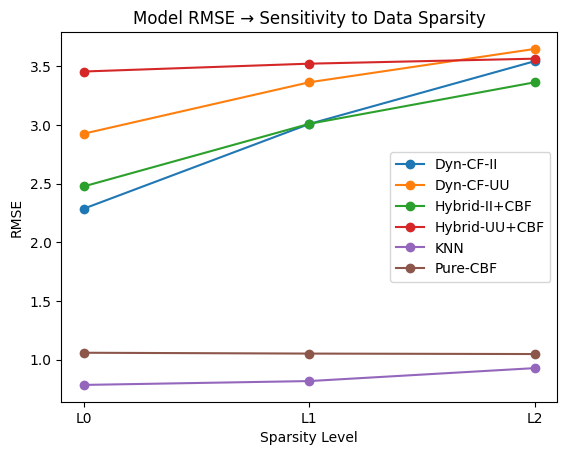

In [23]:
import matplotlib.pyplot as plt

# assume `rmse_df` is your DataFrame with columns ['Level','Model','RMSE']
for model, grp in rmse_df.groupby("Model"):
    plt.plot(grp["Level"], grp["RMSE"], marker="o", label=model)
plt.xlabel("Sparsity Level")
plt.ylabel("RMSE")
plt.title("Model RMSE → Sensitivity to Data Sparsity")
plt.legend()
plt.show()

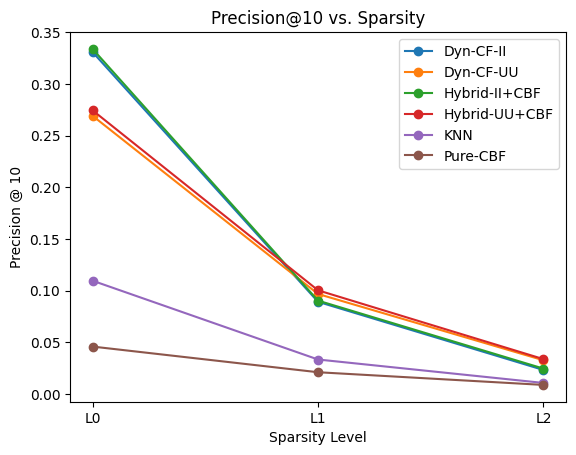

In [24]:
for model, grp in ranking_df.groupby("Model"):
    plt.plot(grp["Level"], grp["P@10"], marker="o", label=model)
plt.xlabel("Sparsity Level")
plt.ylabel("Precision @ 10")
plt.title("Precision@10 vs. Sparsity")
plt.legend()
plt.show()

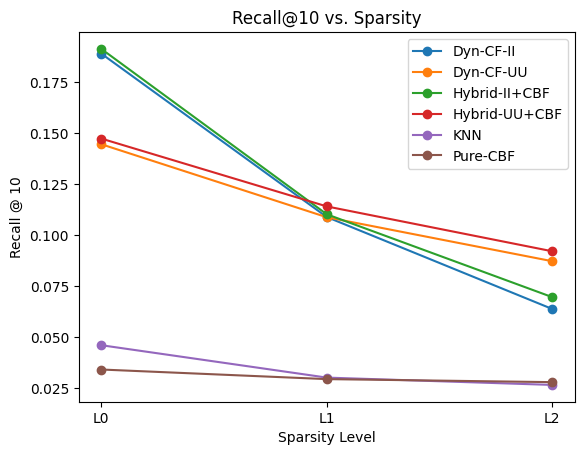

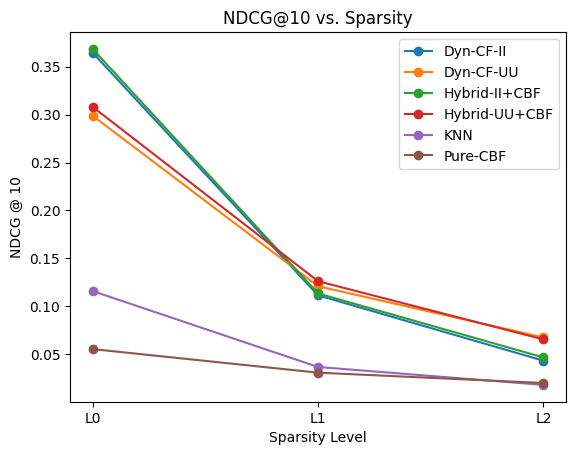

In [25]:
# Recall@10
for model, grp in ranking_df.groupby("Model"):
    plt.plot(grp["Level"], grp["R@10"], marker="o", label=model)
plt.xlabel("Sparsity Level"); plt.ylabel("Recall @ 10")
plt.title("Recall@10 vs. Sparsity")
plt.legend(); plt.show()

# NDCG@10
for model, grp in ranking_df.groupby("Model"):
    plt.plot(grp["Level"], grp["NDCG@10"], marker="o", label=model)
plt.xlabel("Sparsity Level"); plt.ylabel("NDCG @ 10")
plt.title("NDCG@10 vs. Sparsity")
plt.legend(); plt.show()

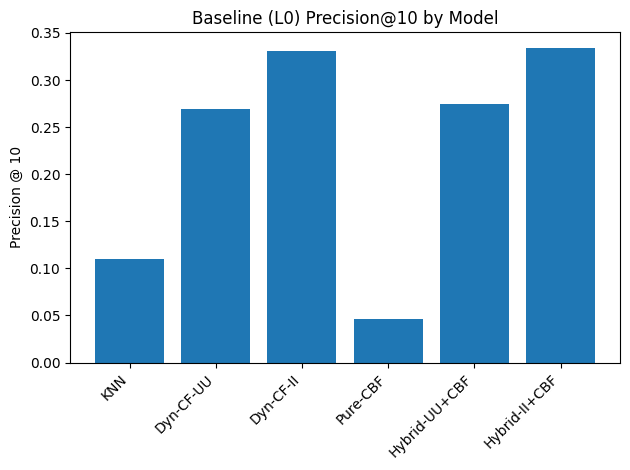

In [26]:
import numpy as np

l0 = ranking_df[ranking_df.Level=="L0"].set_index("Model")
models = l0.index.tolist()
p10     = l0["P@10"].values

x = np.arange(len(models))
plt.bar(x, p10)
plt.xticks(x, models, rotation=45, ha="right")
plt.ylabel("Precision @ 10")
plt.title("Baseline (L0) Precision@10 by Model")
plt.tight_layout()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# Ks = [1,2,5,10,20,50]
# level = "L0"
# truth    = test_sets[level]  # dict user→set(test.movieId)
# train_df = train_splits[level]

# for model_name, model in models.items():
#     precisions = []
#     for K in Ks:
#         Pk = []
#         for u, held in truth.items():
#             recs = model.top_n(train_df, u, K=K)
#             Pk.append( sum(1 for r in recs if r in held) / K )
#         precisions.append( sum(Pk)/len(Pk) )
#     plt.plot(Ks, precisions, marker="o", label=model_name)

# plt.xlabel("K"); plt.ylabel("Precision@K")
# plt.title(f"Precision@K Curves (Sparsity = {level})")
# plt.legend()
# plt.xscale("log", basex=10)
# plt.show()


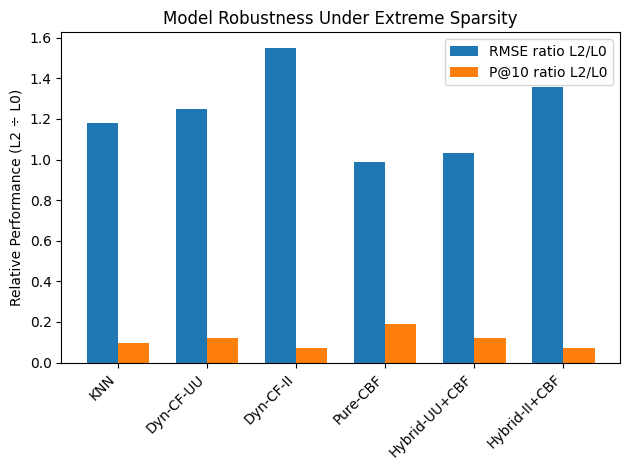

In [28]:
import numpy as np
import matplotlib.pyplot as plt

ratios = []
for name in rmse_df.Model.unique():
    r0 = rmse_df .query("Level=='L0' & Model==@name")["RMSE"].item()
    r2 = rmse_df .query("Level=='L2' & Model==@name")["RMSE"].item()
    p0 = ranking_df.query("Level=='L0' & Model==@name")["P@10"].item()
    p2 = ranking_df.query("Level=='L2' & Model==@name")["P@10"].item()
    ratios.append((name, r2/r0, p2/p0))

names, rmse_ratios, p_ratios = zip(*ratios)
x = np.arange(len(names))
width = 0.35

plt.bar(x - width/2, rmse_ratios, width, label="RMSE ratio L2/L0")
plt.bar(x + width/2, p_ratios,    width, label="P@10 ratio L2/L0")
plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("Relative Performance (L2 ÷ L0)")
plt.title("Model Robustness Under Extreme Sparsity")
plt.legend()
plt.tight_layout()
plt.show()


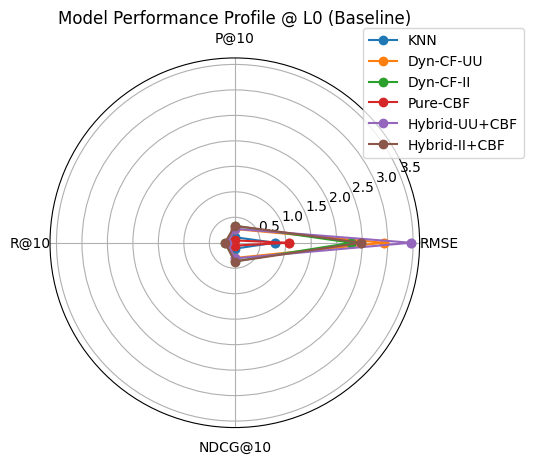

In [30]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["RMSE","P@10","R@10","NDCG@10"]
N = len(metrics)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(subplot_kw=dict(polar=True))
for model_name in rmse_df.Model.unique():
    vals = [
      rmse_df .query("Level=='L0' & Model==@model_name")["RMSE"].item(),
      ranking_df.query("Level=='L0' & Model==@model_name")["P@10"].item(),
      ranking_df.query("Level=='L0' & Model==@model_name")["R@10"].item(),
      ranking_df.query("Level=='L0' & Model==@model_name")["NDCG@10"].item(),
    ]
    vals += vals[:1]
    ax.plot(angles, vals, marker="o", label=model_name)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Model Performance Profile @ L0 (Baseline)")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


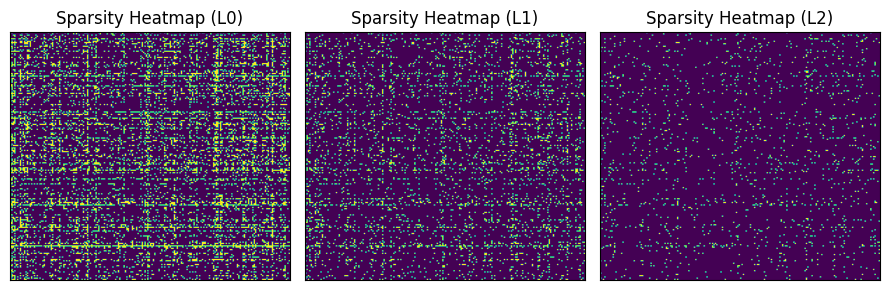

In [31]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(9,3))
for ax, lvl in zip(axes, ["L0","L1","L2"]):
    df = splits[lvl]
    sub = df.pivot(index="userId", columns="movieId", values="rating").fillna(0)
    sub = sub.sample(200, axis=0, random_state=1).sample(200, axis=1, random_state=1)
    ax.imshow((sub>0).astype(int), aspect="auto")
    ax.set_title(f"Sparsity Heatmap ({lvl})")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()
